In [1]:
%autosave 60
import keras 
import numpy as np
import sklearn.model_selection as sk
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras import backend as K
import glob
import os
from keras.applications import VGG19
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras import backend as K
from matplotlib.image import imread
import numpy as np
import random

Autosaving every 60 seconds


Using TensorFlow backend.


### import the Fruit-360 datasets

In [2]:
image_width = 224
image_height = 224

train_data_dir = '../Fruit360/fruits-360/Training/'
test_data_dir = '../Fruit360/fruits-360/Test/'


#generators automatically turn image files on disk into batches of processed tensors 
# use data augmentation 
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.1) #split 10% data as validation dataset 
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=16,
    class_mode='categorical',
    subset='training')
validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=16,
    class_mode='categorical',
    subset='validation')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(image_height, image_width),
    batch_size=16,
    class_mode='categorical')
# all labels in training dataset 
#train_generator.class_indices

Found 44034 images belonging to 95 classes.
Found 4871 images belonging to 95 classes.
Found 16421 images belonging to 95 classes.


In [3]:
#mapping of labels with fruit categories
label_lst = ['Apple Braeburn','Apple Golden 1','Apple Golden 2','Apple Golden 3','Apple Granny Smith','Apple Red 1',
             'Apple Red 2','Apple Red 3','Apple Red Delicious','Apple Red Yellow 1','Apple Red Yellow 2','Apricot',
             'Avocado','Avocado ripe','Banana','Banana Lady Finger','Banana Red','Cactus fruit','Cantaloupe 1',
             'Cantaloupe 2','Carambula','Cherry 1','Cherry 2','Cherry Rainier','Cherry Wax Black','Cherry Wax Red',
             'Cherry Wax Yellow','Chestnut','Clementine','Cocos','Dates','Granadilla','Grape Blue','Grape Pink',
             'Grape White','Grape White 2','Grape White 3','Grape White 4','Grapefruit Pink','Grapefruit White',
             'Guava','Hazelnut','Huckleberry','Kaki','Kiwi','Kumquats','Lemon','Lemon Meyer','Limes','Lychee',
             'Mandarine','Mango','Mangostan','Maracuja','Melon Piel de Sapo','Mulberry','Nectarine','Orange',
             'Papaya','Passion Fruit','Peach','Peach 2','Peach Flat','Pear','Pear Abate','Pear Kaiser','Pear Monster',
             'Pear Williams','Pepino','Physalis','Physalis with Husk','Pineapple','Pineapple Mini','Pitahaya Red',
             'Plum','Plum 2','Plum 3','Pomegranate','Pomelo Sweetie','Quince','Rambutan','Raspberry','Redcurrant',
             'Salak','Strawberry','Strawberry Wedge','Tamarillo','Tangelo','Tomato 1','Tomato 2','Tomato 3','Tomato 4',
             'Tomato Cherry Red','Tomato Maroon','Walnut']
print(len(label_lst))

95


### visualize the images

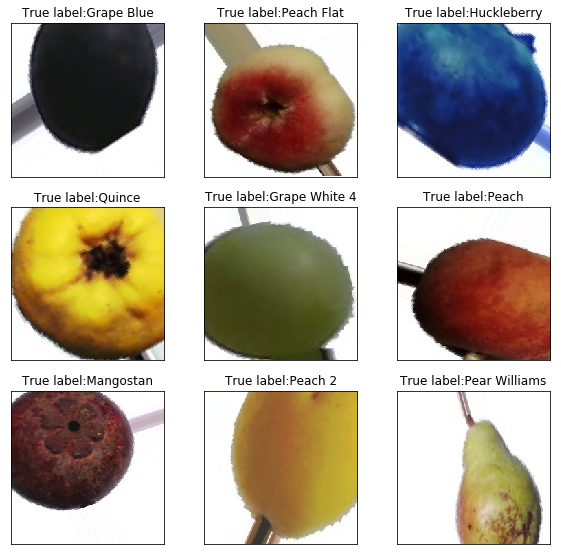

In [4]:
x_batch, y_batch = next(train_generator)

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
for i in range(9):
    plt.subplot(3, 3, i+1);
    plt.tight_layout()
    image = x_batch[i]
    plt.imshow(image)
    index = list(y_batch[i]).index(max(y_batch[i]))
    name = label_lst[index]
    plt.title("True label:{}".format(name))
    plt.xticks([])
    plt.yticks([])
fig

### load the Fruit dataset

In [5]:
#load the training data
x_train = list()
y_train = list()
for img_dir_path in glob.glob('../Fruit360/fruits-360/Training/*'):
    train_label = img_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(img_dir_path, "*.jpg")):
        image = imread(image_path)
        x_train.append(image)
        y_train.append(train_label)

In [6]:
#convert the data type from list to numpy array
#and 
x_train = np.array(x_train)
x_train = x_train.transpose(0,3,1,2)
y_train = np.array(y_train)
print("x_train is a numpy array of size:", np.shape(x_train))
print("y_train is a numpy array of size:", np.shape(y_train))

x_train is a numpy array of size: (48905, 3, 100, 100)
y_train is a numpy array of size: (48905,)


In [7]:
#load the test data
x_test = list()
y_test = list()
for img_dir_path in glob.glob('../Fruit360/fruits-360/Test/*'):
    test_label = img_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(img_dir_path, "*.jpg")):
        image = imread(image_path)
        x_test.append(image)
        y_test.append(test_label)

In [8]:
#convert the data type from list to numpy array
x_test = np.array(x_test)
x_test = x_test.transpose(0,3,1,2)
y_test = np.array(y_test)
print("x_test is a numpy array of size:", np.shape(x_test))
print("y_test is a numpy array of size:", np.shape(y_test))

x_test is a numpy array of size: (16421, 3, 100, 100)
y_test is a numpy array of size: (16421,)


In [9]:
#convert data to dim 2
x_train_flatten = x_train.reshape(48905,30000)
x_test_flatten = x_test.reshape(16421,30000)

In [11]:
%%time
random_forest = RandomForestClassifier(n_estimators=95,bootstrap=True)
random_forest.fit(x_train_flatten, y_train)
rf_score = random_forest.score(x_test_flatten, y_test)
print("The accuracy of random forest on test data is",rf_score)

The accuracy of random forest on test data is 0.9688813105170209
CPU times: user 8min 36s, sys: 1.24 s, total: 8min 37s
Wall time: 8min 37s


In [ ]:
%%time
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_flatten, y_train)
lda_score = lda.score(x_test_flatten, y_test)
print("The accuracy of lda on test data is",lda_score)

In [35]:
%%time
logi_regr = LogisticRegression()
logi_regr.fit(x_train_flatten, y_train)
logi_score = logi_regr.score(x_test_flatten, y_test)
print(logi_score)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9084708604835272
CPU times: user 20h 53min 18s, sys: 24min 16s, total: 21h 17min 34s
Wall time: 21h 17min 1s


In [ ]:
%%time
svm_classifier = svm.SVC(gamma=0.001)
svm_classifier.fit(x_train_flatten,y_train)
svm_score = svm_classifier.score(x_test_flatten, y_test)
print(svm_score)